<a href="https://colab.research.google.com/github/iskra3138/stable-baselines/blob/main/stable_baselines_1_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines Tutorial - Getting Started

Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines: https://github.com/hill-a/stable-baselines

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines zoo: https://github.com/araffin/rl-baselines-zoo

Medium article: [https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82](https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82)

[RL Baselines Zoo](https://github.com/araffin/rl-baselines-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.


## Introduction

In this notebook, you will learn the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.6).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


## Imports

Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html)

##### recap table

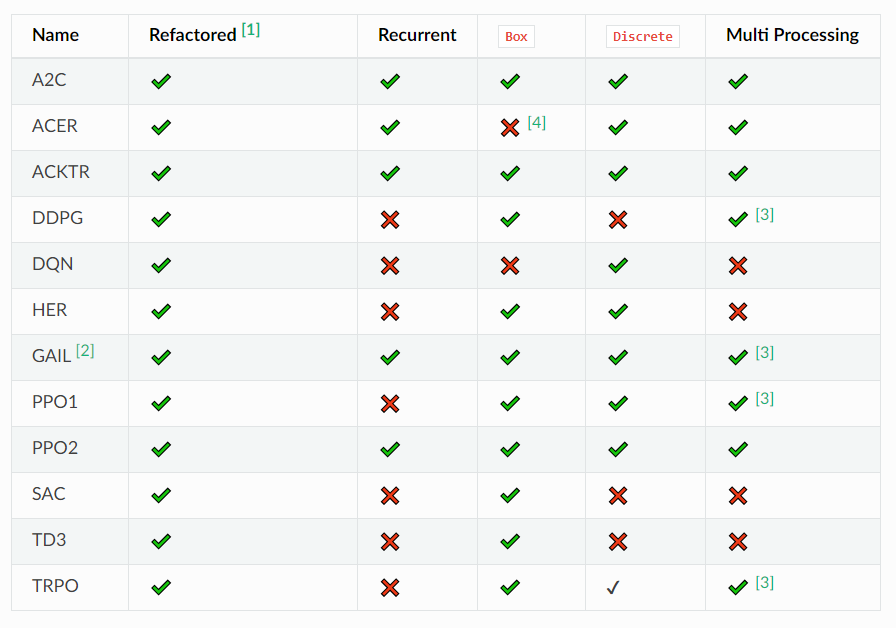

In [ ]:
import gym
import numpy as np

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

- 첫번째로 해야 할 일은 RL model을 불러오는 것.
- 어떤 문제에 무엇을 사용할 수 있는 지 알기 위해 documentation을 확인할 것

In [ ]:
from stable_baselines import PPO2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO2('MlpPolicy', env)``` instead of ```PPO2(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy` (different from `stable_baselines.common.policies.MlpPolicy`), that's why using string for the policy is the recommened option.

- 다음으로 가져와야하는 것은 네트워크를 만드는 데 사용할 policy class (policy/value functions을 위한).
- 생성자(constructor)에서 문자열(strings)을 직접 사용할 수 있으므로, 이 단계는 선택 사항
  - ```PPO2 (MlpPolicy, env)```대신```PPO2 ( 'MlpPolicy', env)```

- `SAC`와 같은 일부 알고리즘에는 자체`MlpPolicy` (`stable_baselines.common.policies.MlpPolicy`와 다름)가 있으므로 policy를 위해 문자열을 사용하는 것이 권장되는 옵션임

In [ ]:
from stable_baselines.common.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.
- CartPole task의 observation은 이미지가 아닌 feature vector이기 때문에 MlpPolicy 선택

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space
- action으로 discrete/continuous중 무엇을 사용할 지는 environment action space로 부터 자동으로 추론됨

Here we are using the [Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm (PPO2 is the version optimized for GPU), which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).
- 여기에서 GPU에 최적화된 PPO2 알고리즘을 이용
- PPO2는 Actor-Critic 방법으로 policy gradient descent를 개선하기 위해 Value function을 이용함

It combines ideas from [A2C](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).
- 이것은 A2C와 TRPO의 아이디어를 조합한 방법
  - A2C는 exploration을 위해 multiple worker를 가지고, entropy bonus를 이용함
  - TRPO는 stability를 개선하기 위해 trust region을 이용하고, 성능면에서 catastrophc drops을 피함

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.
- PPO는 on-policy 알고리즘임
  - 즉, 네트워크들을 업데이트하기 위해 사용되는 trajectory들이 최신 policy를 사용하여 수집됨
- DQN, SAC, TD3같은 off-policy알고리즘들보다는 sample efficiecy가 떨어지지만, 수행시간 관점에서 더 빠름

In [ ]:
env = gym.make('CartPole-v1')

model = PPO2(MlpPolicy, env, verbose=0)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





We create a helper function to evaluate the agent:
- agent를 평가하는 helper 함수를 선언함

In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    # single Environment에 대해서만 작동함
    env = model.get_env() 
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset() # e.g. [[ 0.04632042, -0.01863058, -0.03169358,  0.00881829]])
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs) # e.g.: [0], None
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action) #e.g.: [[0.04, -0.24, -0.03, 0.27]], [1.0], [False], [{}]
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

##### evaluat 함수 코드 분석

In [ ]:
#YJ
env.reset()

array([[ 0.04632042, -0.01863058, -0.03169358,  0.00881829]],
      dtype=float32)

In [ ]:
#YJ
model.predict(env.reset())

(array([0]), None)

In [ ]:
#YJ
env.step(model.predict(env.reset())[0])

(array([[ 0.0434584 , -0.24000068, -0.03723486,  0.27221394]],
       dtype=float32), array([1.], dtype=float32), array([False]), [{}])

##### original code 복귀

Let's evaluate the un-trained agent, this should be a random agent.
- 학습되지 않은 agent 평가해보기

In [ ]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100)

Mean reward: 22.66 Num episodes: 100


Stable-Baselines already provides you with that helper:
- Satble-Baselines는 이미 해당 helper를 가지고 있음

In [ ]:
from stable_baselines.common.evaluation import evaluate_policy

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:500.00 +/- 0.00


## Train the agent and evaluate it

In [ ]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:428.41 +/- 77.26


In [ ]:
# YJ
# Trained Agent, After training
mean_reward_before_train = evaluate(model, num_episodes=100)

Mean reward: 126.21 Num episodes: 100


Apparently the training went well, the mean reward increased a lot ! 

**새로 정의한 evaluate 함수와 내포된 evaluate_policy 결과가 너무 다름!!!  나중에 seed 고정하고 비교해보아야 함**

### Prepare video recording

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [ ]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualize trained agent



In [ ]:
record_video('CartPole-v1', model, video_length=500, prefix='ppo2-cartpole')

In [ ]:
show_videos('videos', prefix='ppo2')

## Bonus: Train a RL Model in One Line

The policy class to use will be inferred and the environment will be automatically created. This works because both are [registered](https://stable-baselines.readthedocs.io/en/master/guide/quickstart.html).

In [ ]:
model = PPO2('MlpPolicy', "CartPole-v1", verbose=1).learn(1000)

Creating environment from the given name, wrapped in a DummyVecEnv.
--------------------------------------
| approxkl           | 0.00022001716 |
| clipfrac           | 0.0           |
| explained_variance | 0.062         |
| fps                | 278           |
| n_updates          | 1             |
| policy_entropy     | 0.69295824    |
| policy_loss        | -0.005195465  |
| serial_timesteps   | 128           |
| time_elapsed       | 1.31e-05      |
| total_timesteps    | 128           |
| value_loss         | 38.741753     |
--------------------------------------
-------------------------------------
| approxkl           | 7.630998e-05 |
| clipfrac           | 0.0          |
| explained_variance | 0.00748      |
| fps                | 446          |
| n_updates          | 2            |
| policy_entropy     | 0.6920499    |
| policy_loss        | 7.297669e-05 |
| serial_timesteps   | 256          |
| time_elapsed       | 0.461        |
| total_timesteps    | 256          |
| value

In [ ]:
#YJ
#이전방식
env = gym.make('CartPole-v1')
model = PPO2(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1000)

Wrapping the env in a DummyVecEnv.
--------------------------------------
| approxkl           | 0.00014336246 |
| clipfrac           | 0.0           |
| explained_variance | -0.0098       |
| fps                | 286           |
| n_updates          | 1             |
| policy_entropy     | 0.69299984    |
| policy_loss        | -0.0033858928 |
| serial_timesteps   | 128           |
| time_elapsed       | 1.84e-05      |
| total_timesteps    | 128           |
| value_loss         | 40.028652     |
--------------------------------------
--------------------------------------
| approxkl           | 8.52109e-05   |
| clipfrac           | 0.0           |
| explained_variance | 0.0178        |
| fps                | 475           |
| n_updates          | 2             |
| policy_entropy     | 0.6924134     |
| policy_loss        | -0.0026756327 |
| serial_timesteps   | 256           |
| time_elapsed       | 0.448         |
| total_timesteps    | 256           |
| value_loss         | 75.499

## Train a DQN agent

In the previous example, we have used PPO, which one of the many algorithms provided by stable-baselines.
- 앞 선 예제는 stabel-baselines가 제공하는 많은 알고리듬 중 하나인 PPO를 이용

In the next example, we are going train a [Deep Q-Network agent (DQN)](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), and try to see possible improvements provided by its extensions (Double-DQN, Dueling-DQN, Prioritized Experience Replay).
- 다음 예제에서는 DQN을 이용해서 학습
- Double-DQN, Dueling-DQN, Prioritized Experience Replay같은 확장알고리즘들에 의해 제공되는 가능한 개선점들을 보겠음

The essential point of this section is to show you how simple it is to tweak hyperparameters.
- 이 섹션의 필수 포인트는 hyperparameter를 조정하는 것이 매우 간단하는 것을 보여주는 것

The main advantage of stable-baselines is that it provides a common interface to use the algorithms, so the code will be quite similar.
- stable-baselines의 주요 이점은 알고리즘 사용에 공통적인 interface를 제공한다는 것임. 코드 사용이 매우 유사해짐


DQN paper: https://arxiv.org/abs/1312.5602

Dueling DQN: https://arxiv.org/abs/1511.06581

Double-Q Learning: https://arxiv.org/abs/1509.06461

Prioritized Experience Replay: https://arxiv.org/abs/1511.05952

### Vanilla DQN: DQN without extensions

In [ ]:
# Same as before we instantiate the agent along with the environment
from stable_baselines import DQN

# Deactivate all the DQN extensions to have the original version
# In practice, it is recommend to have them activated
# 본 예제에서는 모든 확장 기능을 비활성화시킴. 실제에서는 모두 활성화하길 추천함
kwargs = {'double_q': False, 'prioritized_replay': False, 'policy_kwargs': dict(dueling=False)}

# Note that the MlpPolicy of DQN is different from the one of PPO
# but stable-baselines handles that automatically if you pass a string
# DQN의 MlpPolicy는 PPO의 그것과 다르지만 string argument를 이용해서 자동으로 적절할 MlpPolicy가 선택됨
dqn_model = DQN('MlpPolicy', 'CartPole-v1', verbose=1, **kwargs)

Creating environment from the given name, wrapped in a DummyVecEnv.


In [ ]:
# Random Agent, before training
mean_reward_before_train = evaluate(dqn_model, num_episodes=100)

Mean reward: 14.46 Num episodes: 100


In [ ]:
# YJ
mean_reward, std_reward = evaluate_policy(dqn_model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:13.85 +/- 11.70


In [ ]:
# Train the agent for 10000 steps
dqn_model.learn(total_timesteps=10000, log_interval=10)


--------------------------------------
| % time spent exploring  | 81       |
| episodes                | 10       |
| mean 100 episode reward | 21.2     |
| steps                   | 191      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 63       |
| episodes                | 20       |
| mean 100 episode reward | 19.7     |
| steps                   | 375      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 49       |
| episodes                | 30       |
| mean 100 episode reward | 17.8     |
| steps                   | 516      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 38       |
| episodes                | 40       |
| mean 100 episode reward | 16.2     |
| steps                   | 632      |
--------------------------------------
--------------------------------------
| % time spent exploring

In [ ]:
# Evaluate the trained agent
mean_reward = evaluate(dqn_model, num_episodes=100)

Mean reward: 178.89 Num episodes: 100


In [ ]:
# YJ
mean_reward, std_reward = evaluate_policy(dqn_model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:179.78 +/- 16.73


### DQN + Prioritized Replay

In [ ]:
# Activate only the prioritized replay
# 'prioritized replay'만 활성화
kwargs = {'double_q': False, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=False)}

dqn_per_model = DQN('MlpPolicy', 'CartPole-v1', verbose=1, **kwargs)

Creating environment from the given name, wrapped in a DummyVecEnv.


In [ ]:
dqn_per_model.learn(total_timesteps=10000, log_interval=10)

--------------------------------------
| % time spent exploring  | 82       |
| episodes                | 10       |
| mean 100 episode reward | 19.7     |
| steps                   | 177      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 67       |
| episodes                | 20       |
| mean 100 episode reward | 17.3     |
| steps                   | 328      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 51       |
| episodes                | 30       |
| mean 100 episode reward | 16.9     |
| steps                   | 491      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 38       |
| episodes                | 40       |
| mean 100 episode reward | 16.1     |
| steps                   | 628      |
--------------------------------------
--------------------------------------
| % time spent exploring 

In [ ]:
# Evaluate the trained agent
mean_reward = evaluate(dqn_per_model, num_episodes=100)

Mean reward: 196.15 Num episodes: 100


### DQN + Prioritized Experience Replay + Double Q-Learning + Dueling

In [ ]:
# Activate all extensions
kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)}

dqn_full_model = DQN('MlpPolicy', 'CartPole-v1', verbose=1, **kwargs)

Creating environment from the given name, wrapped in a DummyVecEnv.


In [ ]:
dqn_full_model.learn(total_timesteps=10000, log_interval=10)

--------------------------------------
| % time spent exploring  | 83       |
| episodes                | 10       |
| mean 100 episode reward | 18.2     |
| steps                   | 164      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 69       |
| episodes                | 20       |
| mean 100 episode reward | 16.4     |
| steps                   | 312      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 56       |
| episodes                | 30       |
| mean 100 episode reward | 15.2     |
| steps                   | 442      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 44       |
| episodes                | 40       |
| mean 100 episode reward | 14.6     |
| steps                   | 568      |
--------------------------------------
--------------------------------------
| % time spent exploring 

In [ ]:
mean_reward = evaluate(dqn_per_model, num_episodes=100)

Mean reward: 201.47 Num episodes: 100


In this particular example, the extensions does not seem to give any improvement compared to the simple DQN version.
- Mean reward
  - simple: : 178.89, one_extension: 196.15, all_extension: 201.47

They are several reasons for that:
- extension이 큰 개선효과를 나타내지 못한 것에 다음과 같은 이유가 있음
1. `CartPole-v1` is a pretty simple environment
- 'CartPole-v1'은 꽤 단순한 환경임
2. We trained DQN for very few timesteps, not enough to see any difference
- 어떤 차별점을 보기에는 너무 작은 기간동안만 학습했음
3. The default hyperparameters for DQN are tuned for atari games, where the number of training timesteps is much larger (10^6) and input observations are images
- DQN을 Default HP값은 atari games에 맞춰져 있음. atari game에서의 training timesteps는 훨씬 더 크고(10^6), input observation이 이미지임
4. We have only compared one random seed per experiment
- 실험 당 오직 하나의 랜덤 시드만 비교했음

## Conclusion

In this notebook we have seen:
- how to define and train a RL model using stable baselines, it takes only one line of code ;)
- how to use different RL algorithms and change some hyperparameters

- 이번 노트북을 통해 
  - stable baselines로 RL model을 정의하고 학습하는 방법을 배움
  - 서로 다른 RL 알고리즘을 이용하는 방법과 약간의 HP를 바꾸는 방법을 배움

### DQN training step 증가시켜 비교해보기 (YJ)
simple: : 178.89, one_extension: 196.15, all_extension: 201.47

In [ ]:
# Simple(YJ)
kwargs = {'double_q': False, 'prioritized_replay': False, 'policy_kwargs': dict(dueling=False)}
dqn_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)
dqn_model.learn(total_timesteps=1000000, log_interval=10)
mean_reward = evaluate(dqn_model, num_episodes=100)

Mean reward: 96.54 Num episodes: 100


In [ ]:
# One_extension(YJ)
kwargs = {'double_q': False, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=False)}
dqn_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)
dqn_model.learn(total_timesteps=1000000, log_interval=10)
mean_reward = evaluate(dqn_model, num_episodes=100)

Mean reward: 500.0 Num episodes: 100


In [ ]:
# All_extensions(YJ)
kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)}
dqn_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)
dqn_model.learn(total_timesteps=1000000, log_interval=10)
mean_reward = evaluate(dqn_model, num_episodes=100)

Mean reward: 96.73 Num episodes: 100
